In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import ast
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
from tqdm import tqdm
import logging
from typing import List, Dict, Tuple, Any
from google.colab import files

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from typing import Optional

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df_relevant = pd.read_parquet('drive/MyDrive/NLP/df_relevant.parquet', engine='pyarrow')
df_relevant.shape

(150466, 6)

In [5]:
resolved_entities = pd.read_csv('drive/MyDrive/NLP/resolved_entities.csv')
resolved_entities.shape

(150466, 7)

In [6]:
resolved_entities = resolved_entities[['entities_person_resolved', 'entities_org_resolved', 'entities_tech_resolved']].copy()
resolved_entities.shape

(150466, 3)

In [7]:
# Concatenate the text column in the cleaned full dataframe with the NER extracted entities
text_entities = pd.concat([df_relevant['text'], resolved_entities], axis=1)
text_entities.shape

(150466, 4)

In [8]:
display(text_entities.head())

,text,entities_person_resolved,entities_org_resolved,entities_tech_resolved
0,Artificial intelligence Caledon Citizen Member...,"['Grandma', 'Joey', 'Isaac Asimov', 'Danger Wi...","['Blame Game Scheduling', 'Caledon Cavaliers',...","['Robot', 'Artificial Intelligence']"
1,Civilization Call To Power 25th Anniversary Ce...,"['Multiplayer Server', 'List Calendar', 'https...","['Celebration - Communities', 'Fan Mods Ports'...",['Artificial Intelligence']
2,AI workshop held at Temple Trees to enhance pu...,"['Hans Wijesuriya', 'Sanjaya Karunaseena', 'Ha...","['Temple Trees', 'Digital Economy', 'Informati...",['Artificial Intelligence']
3,China s DeepSeek Breakthrough and What it Mean...,"['Breakthrough', 'edIn X', 'Joe Biden', 'Trump...","['Pin 0 s', 'White House', 'U.S', 'ANALYSIS', ...","['DeepSeek', 'Artificial Intelligence', 'Mobil..."
4,"Colvin Ph.D. 99, LaMoreaux 01 to Discuss Impac...","['Colvin Ph.D', 'Alex Colvin', 'Dean', 'Nickle...","['Cornell Daily Sun', 'Men s Hockey Women', 'G...","['iPhone', 'Mobile Application', 'Artificial I..."


In [9]:
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

For sentiment analysis, I use a pre-trained aspect-based sentiment analysis (ABSA) model, as it directly handles entity-level (aspect) sentiments without custom training. A strong, ready-to-use option is "yangheng/deberta-v3-base-absa-v1.1" from Hugging Face, which classifies polarity (positive, negative, neutral) for a given entity in the text. It's based on DeBERTa and performs well on news-like data, with high accuracy on benchmarks like SemEval.

In [13]:
class EntitySentimentAnalyzer:
    def __init__(self, model_name: str = "yangheng/deberta-v3-base-absa-v1.1"):
        """
        Initialize the ABSA model for entity sentiment analysis
        """
        self.model_name = model_name
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        logger.info(f"Using device: {self.device}")

        # Load the pre-trained ABSA model
        try:
            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
            self.model.to(self.device)
            self.model.eval()
            logger.info(f"Successfully loaded model: {model_name}")
        except Exception as e:
            logger.error(f"Error loading model: {e}")
            # Fallback to a general sentiment model
            self.model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
            self.sentiment_pipeline = pipeline(
                "sentiment-analysis",
                model=self.model_name,
                device=0 if torch.cuda.is_available() else -1
            )
            logger.info(f"Using fallback model: {self.model_name}")

    def extract_all_entities(self, df: pd.DataFrame, top_n: int = 50) -> List[str]:
        """
        Extract and rank the most frequent entities across all categories
        """
        logger.info("Extracting and ranking entities...")

        entity_counter = Counter()
        entity_columns = ['entities_person_resolved', 'entities_org_resolved', 'entities_tech_resolved']

        for col in entity_columns:
            if col in df.columns:
                for entities_str in df[col].dropna():
                    try:
                        # Parse the string representation of list
                        if isinstance(entities_str, str):
                            entities = ast.literal_eval(entities_str)
                        else:
                            entities = entities_str

                        if isinstance(entities, list):
                            for entity in entities:
                                if isinstance(entity, str) and len(entity.strip()) > 2:
                                    entity_counter[entity.strip()] += 1
                    except (ValueError, SyntaxError) as e:
                        # Skip malformed entries
                        continue

        top_entities = [entity for entity, count in entity_counter.most_common(top_n)]
        logger.info(f"Found {len(entity_counter)} unique entities, analyzing top {len(top_entities)}")

        # Print top entities for verification
        print("Top 50 entities by frequency:")
        for i, (entity, count) in enumerate(entity_counter.most_common(50)):
            print(f"{i+1:2d}. {entity:<50} ({count} mentions)")

        return top_entities

    def find_entity_mentions(self, df: pd.DataFrame, entity: str) -> List[Tuple[int, str]]:
        """
        Find all text rows that mention a specific entity
        Returns list of (index, text) tuples
        """
        mentions = []
        entity_columns = ['entities_person_resolved', 'entities_org_resolved', 'entities_tech_resolved']

        for idx, row in df.iterrows():
            text = row.get('text', '')
            if not isinstance(text, str) or len(text.strip()) < 10:
                continue

            # Check if entity is mentioned in any of the entity columns
            entity_found = False
            for col in entity_columns:
                if col in row and pd.notna(row[col]):
                    try:
                        entities_str = row[col]
                        if isinstance(entities_str, str):
                            entities = ast.literal_eval(entities_str)
                        else:
                            entities = entities_str

                        if isinstance(entities, list) and entity in entities:
                            entity_found = True
                            break
                    except (ValueError, SyntaxError):
                        continue

            if entity_found:
                mentions.append((idx, text))

        return mentions

    def analyze_sentiment_batch(self, texts: List[str], entity: str, batch_size: int = 16) -> List[Dict]:
        """
        Analyze sentiment for a batch of texts mentioning an entity
        """
        results = []

        # Process in batches to avoid memory issues
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]

            try:
                if hasattr(self, 'sentiment_pipeline'):
                    # Using fallback sentiment pipeline
                    batch_results = self.sentiment_pipeline(batch_texts)
                    for text, result in zip(batch_texts, batch_results):
                        # Map labels to standard format
                        label = result['label'].upper()
                        if 'POS' in label:
                            sentiment = 'POSITIVE'
                        elif 'NEG' in label:
                            sentiment = 'NEGATIVE'
                        else:
                            sentiment = 'NEUTRAL'

                        results.append({
                            'text': text,
                            'entity': entity,
                            'sentiment': sentiment,
                            'confidence': result['score']
                        })
                else:
                    # Using ABSA model
                    for text in batch_texts:
                        # For ABSA, we need to format the input as "[CLS] text [SEP] entity [SEP]"
                        absa_input = f"{text} [SEP] {entity}"

                        # Tokenize and predict
                        inputs = self.tokenizer(
                            absa_input,
                            return_tensors="pt",
                            truncation=True,
                            max_length=512,
                            padding=True
                        ).to(self.device)

                        with torch.no_grad():
                            outputs = self.model(**inputs)
                            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

                        # Map predictions to sentiment labels
                        pred_class = torch.argmax(predictions, dim=-1).item()
                        confidence = predictions[0][pred_class].item()

                        # Assuming 0: Negative, 1: Neutral, 2: Positive (adjust based on actual model)
                        sentiment_map = {0: 'NEGATIVE', 1: 'NEUTRAL', 2: 'POSITIVE'}
                        sentiment = sentiment_map.get(pred_class, 'NEUTRAL')

                        results.append({
                            'text': text,
                            'entity': entity,
                            'sentiment': sentiment,
                            'confidence': confidence
                        })

            except Exception as e:
                logger.warning(f"Error processing batch for entity '{entity}': {e}")
                # Add neutral results for failed batch
                for text in batch_texts:
                    results.append({
                        'text': text,
                        'entity': entity,
                        'sentiment': 'NEUTRAL',
                        'confidence': 0.5
                    })

        return results

    def analyze_entity_sentiments(self, df: pd.DataFrame, top_entities: List[str],
                                max_mentions_per_entity: int = 100) -> pd.DataFrame:
        """
        Analyze sentiments for all top entities
        """
        all_results = []

        for entity in tqdm(top_entities, desc="Analyzing entity sentiments"):
            logger.info(f"Processing entity: {entity}")

            # Find mentions of this entity
            mentions = self.find_entity_mentions(df, entity)

            if not mentions:
                logger.warning(f"No mentions found for entity: {entity}")
                continue

            # Limit mentions to avoid overwhelming processing
            if len(mentions) > max_mentions_per_entity:
                mentions = mentions[:max_mentions_per_entity]

            # Extract texts for batch processing
            texts = [text for _, text in mentions]
            indices = [idx for idx, _ in mentions]

            # Analyze sentiments
            sentiment_results = self.analyze_sentiment_batch(texts, entity)

            # Add row indices to results
            for result, row_idx in zip(sentiment_results, indices):
                result['row_index'] = row_idx
                all_results.append(result)

        return pd.DataFrame(all_results)

    def aggregate_entity_sentiments(self, sentiment_df: pd.DataFrame) -> pd.DataFrame:
        """
        Aggregate sentiment results per entity
        """
        logger.info("Aggregating sentiment results...")

        aggregated_results = []

        for entity in sentiment_df['entity'].unique():
            entity_data = sentiment_df[sentiment_df['entity'] == entity]

            # Count sentiments
            sentiment_counts = entity_data['sentiment'].value_counts()
            total_mentions = len(entity_data)

            # Calculate percentages
            positive_count = sentiment_counts.get('POSITIVE', 0)
            negative_count = sentiment_counts.get('NEGATIVE', 0)
            neutral_count = sentiment_counts.get('NEUTRAL', 0)

            # Calculate average confidence
            avg_confidence = entity_data['confidence'].mean()

            # Calculate sentiment score (-1 to 1)
            sentiment_score = (positive_count - negative_count) / total_mentions if total_mentions > 0 else 0

            # Determine overall sentiment
            if sentiment_score > 0.1:
                overall_sentiment = 'POSITIVE'
            elif sentiment_score < -0.1:
                overall_sentiment = 'NEGATIVE'
            else:
                overall_sentiment = 'NEUTRAL'

            aggregated_results.append({
                'entity': entity,
                'total_mentions': total_mentions,
                'positive_count': positive_count,
                'negative_count': negative_count,
                'neutral_count': neutral_count,
                'positive_pct': (positive_count / total_mentions) * 100,
                'negative_pct': (negative_count / total_mentions) * 100,
                'neutral_pct': (neutral_count / total_mentions) * 100,
                'sentiment_score': sentiment_score,
                'overall_sentiment': overall_sentiment,
                'avg_confidence': avg_confidence
            })

        return pd.DataFrame(aggregated_results).sort_values('sentiment_score', ascending=False)


In [14]:
def main_analysis(text_entities_df: pd.DataFrame, top_n_entities: int = 30) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Main function to run the complete entity sentiment analysis
    """
    print(f"Starting sentiment analysis for dataset with {len(text_entities_df)} rows...")

    # Initialize analyzer
    analyzer = EntitySentimentAnalyzer()

    # Extract top entities
    top_entities = analyzer.extract_all_entities(text_entities_df, top_n_entities)

    # Analyze sentiments
    print(f"\nAnalyzing sentiments for {len(top_entities)} entities...")
    detailed_results = analyzer.analyze_entity_sentiments(text_entities_df, top_entities)

    # Aggregate results
    aggregated_results = analyzer.aggregate_entity_sentiments(detailed_results)

    print(f"\nCompleted analysis!")
    print(f"Processed {len(detailed_results)} entity-text pairs")
    print(f"Generated aggregated results for {len(aggregated_results)} entities")

    return detailed_results, aggregated_results

In [15]:
# Run the analysis
analyzer = EntitySentimentAnalyzer()
print(f"Number of unique entities: {len(analyzer.extract_all_entities(text_entities))}")
detailed_results, summary_results = main_analysis(text_entities, top_n_entities=50)

# View results
print("Most Positive Entities:")
print(summary_results.head(10))

print("\nMost Negative Entities:")
print(summary_results.tail(10))


# Save the resolved DataFrame to a CSV file
summary_results.to_csv('summary_entity_sentiment_results.csv', index=False)
detailed_results.to_csv('detailed_entity_sentiment_results.csv', index=False)

# Provide a link to download the file
files.download('summary_entity_sentiment_results.csv')
files.download('detailed_entity_sentiment_results.csv')

Top 50 entities by frequency:
 1. Artificial Intelligence                            (148817 mentions)
 2. Mobile Application                                 (51811 mentions)
 3. Software                                           (37137 mentions)
 4. OpenAI                                             (31666 mentions)
 5. Innovation                                         (30033 mentions)
 6. Google                                             (29133 mentions)
 7. Microsoft                                          (24979 mentions)
 8. chatbot                                            (19601 mentions)
 9. AutoMation                                         (14541 mentions)
10. CryptoCurrency                                     (14104 mentions)
11. ANDROID                                            (13542 mentions)
12. Apple                                              (12318 mentions)
13. Cybersecurity                                      (12137 mentions)
14. iPhone                       

Analyzing entity sentiments: 100%|██████████| 50/50 [22:45<00:00, 27.31s/it]



Completed analysis!
Processed 5000 entity-text pairs
Generated aggregated results for 50 entities
Most Positive Entities:
                entity  total_mentions  positive_count  negative_count  \
31                 LLC             100              61               2   
21             Windows             100              49               0   
14          blockchain             100              46               1   
30            Robotics             100              43               1   
40  Internet of Things             100              42               0   
17                Chip             100              43               1   
19                 IOS             100              40               0   
8           AutoMation             100              39               0   
28               Robot             100              40               1   
13              iPhone             100              38               1   

    neutral_count  positive_pct  negative_pct  neutral_pct  se

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
summary_results

,entity,total_mentions,positive_count,negative_count,neutral_count,positive_pct,negative_pct,neutral_pct,sentiment_score,overall_sentiment,avg_confidence
31,LLC,100,61,2,37,61.0,2.0,37.0,0.59,POSITIVE,0.587782
21,Windows,100,49,0,51,49.0,0.0,51.0,0.49,POSITIVE,0.643469
14,blockchain,100,46,1,53,46.0,1.0,53.0,0.45,POSITIVE,0.642217
30,Robotics,100,43,1,56,43.0,1.0,56.0,0.42,POSITIVE,0.642921
40,Internet of Things,100,42,0,58,42.0,0.0,58.0,0.42,POSITIVE,0.634375
17,Chip,100,43,1,56,43.0,1.0,56.0,0.42,POSITIVE,0.694862
19,IOS,100,40,0,60,40.0,0.0,60.0,0.40,POSITIVE,0.703534
8,AutoMation,100,39,0,61,39.0,0.0,61.0,0.39,POSITIVE,0.640606
28,Robot,100,40,1,59,40.0,1.0,59.0,0.39,POSITIVE,0.686934
13,iPhone,100,38,1,61,38.0,1.0,61.0,0.37,POSITIVE,0.659104


In [17]:
detailed_results

,text,entity,sentiment,confidence,row_index
0,Artificial intelligence Caledon Citizen Member...,Artificial Intelligence,NEUTRAL,0.742872,0
1,Civilization Call To Power 25th Anniversary Ce...,Artificial Intelligence,NEUTRAL,0.900239,1
2,AI workshop held at Temple Trees to enhance pu...,Artificial Intelligence,NEUTRAL,0.775720,2
3,China s DeepSeek Breakthrough and What it Mean...,Artificial Intelligence,NEUTRAL,0.503381,3
4,"Colvin Ph.D. 99, LaMoreaux 01 to Discuss Impac...",Artificial Intelligence,NEUTRAL,0.869391,4
...,...,...,...,...,...
4995,Construction Tech Startup Mercator AI To Accel...,Samsung,POSITIVE,0.863388,6882
4996,Coveo AI and Recommendations Platform for SAP ...,Samsung,POSITIVE,0.905006,6883
4997,Coveo s Relevance AI Platform Wins Coveted Bes...,Samsung,POSITIVE,0.863661,6884
4998,DIAGNOS and the CHUM are launching the testing...,Samsung,POSITIVE,0.702583,6888


## Visualize the sentiment for the top 50 entities

In [19]:
# Set style for matplotlib
plt.style.use('default')
sns.set_palette("husl")

class EntitySentimentVisualizer:
    def __init__(self, df: pd.DataFrame):
        """
        Initialize with the sentiment results dataframe
        """
        self.df = df.copy()
        self.df = self.df.head(50)  # Top 50 entities

        # Define color scheme
        self.colors = {
            'POSITIVE': '#2E8B57',    # Sea Green
            'NEGATIVE': '#DC143C',    # Crimson
            'NEUTRAL': '#708090'      # Slate Gray
        }

        print(f"Loaded data for {len(self.df)} entities")

    def create_sentiment_distribution_bar(self, figsize: tuple = (15, 8)) -> None:
        """
        Create a horizontal bar chart showing sentiment distribution for each entity
        """
        fig, ax = plt.subplots(figsize=figsize)

        # Prepare data for stacked horizontal bar chart
        entities = self.df['entity'][:25]  # Top 25 for readability
        positive_pcts = self.df['positive_pct'][:25]
        negative_pcts = self.df['negative_pct'][:25]
        neutral_pcts = self.df['neutral_pct'][:25]

        # Create stacked horizontal bar chart
        bar_width = 0.8
        y_pos = np.arange(len(entities))

        # Create bars
        p1 = ax.barh(y_pos, positive_pcts, bar_width,
                    label='Positive', color=self.colors['POSITIVE'], alpha=0.8)
        p2 = ax.barh(y_pos, negative_pcts, bar_width, left=positive_pcts,
                    label='Negative', color=self.colors['NEGATIVE'], alpha=0.8)
        p3 = ax.barh(y_pos, neutral_pcts, bar_width,
                    left=positive_pcts + negative_pcts,
                    label='Neutral', color=self.colors['NEUTRAL'], alpha=0.8)

        # Customize chart
        ax.set_yticks(y_pos)
        ax.set_yticklabels(entities)
        ax.invert_yaxis()
        ax.set_xlabel('Percentage of Mentions')
        ax.set_title('Sentiment Distribution by Entity (Top 25)', fontsize=16, fontweight='bold')
        ax.legend(loc='lower right')
        ax.grid(axis='x', alpha=0.3)

        # Add percentage labels on bars
        for i, (pos, neg, neu) in enumerate(zip(positive_pcts, negative_pcts, neutral_pcts)):
            if pos > 5:  # Only show if segment is large enough
                ax.text(pos/2, i, f'{pos:.0f}%', ha='center', va='center', fontweight='bold')
            if neg > 5:
                ax.text(pos + neg/2, i, f'{neg:.0f}%', ha='center', va='center', fontweight='bold')
            if neu > 5:
                ax.text(pos + neg + neu/2, i, f'{neu:.0f}%', ha='center', va='center', fontweight='bold')

        plt.tight_layout()
        plt.show()

    def create_sentiment_score_plot(self, figsize: tuple = (14, 8)) -> None:
        """
        Create a scatter plot of sentiment scores with entity labels
        """
        fig, ax = plt.subplots(figsize=figsize)

        # Create color mapping based on overall sentiment
        colors = [self.colors[sentiment] for sentiment in self.df['overall_sentiment']]

        # Create scatter plot
        scatter = ax.scatter(self.df['sentiment_score'], self.df['total_mentions'],
                           c=colors, s=100, alpha=0.7, edgecolors='black', linewidth=0.5)

        # Add entity labels for top entities
        for i, (entity, score, mentions) in enumerate(zip(self.df['entity'][:15],
                                                         self.df['sentiment_score'][:15],
                                                         self.df['total_mentions'][:15])):
            ax.annotate(entity, (score, mentions), xytext=(5, 5),
                       textcoords='offset points', fontsize=9, alpha=0.8)

        # Customize plot
        ax.set_xlabel('Sentiment Score (-1 = Most Negative, 1 = Most Positive)', fontsize=12)
        ax.set_ylabel('Total Mentions', fontsize=12)
        ax.set_title('Entity Sentiment Score vs Mention Frequency', fontsize=16, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.axvline(x=0, color='black', linestyle='--', alpha=0.5, label='Neutral')

        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=self.colors['POSITIVE'], label='Positive'),
                          Patch(facecolor=self.colors['NEUTRAL'], label='Neutral'),
                          Patch(facecolor=self.colors['NEGATIVE'], label='Negative')]
        ax.legend(handles=legend_elements, loc='upper right')

        plt.tight_layout()
        plt.show()

    def create_interactive_dashboard(self) -> go.Figure:
        """
        Create an interactive Plotly dashboard with multiple visualizations
        """
        # Create subplots
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Sentiment Score Distribution', 'Top Positive vs Negative Entities',
                           'Sentiment Composition (Top 20)', 'Entity Confidence vs Sentiment'),
            specs=[[{"secondary_y": False}, {"secondary_y": False}],
                   [{"secondary_y": False}, {"secondary_y": False}]]
        )

        # 1. Sentiment Score Distribution (Histogram)
        fig.add_trace(
            go.Histogram(x=self.df['sentiment_score'],
                        name='Sentiment Score Distribution',
                        marker_color='skyblue',
                        opacity=0.7),
            row=1, col=1
        )

        # 2. Top Positive vs Negative Entities (Bar chart)
        top_positive = self.df.nlargest(10, 'sentiment_score')
        top_negative = self.df.nsmallest(10, 'sentiment_score')

        fig.add_trace(
            go.Bar(x=top_positive['sentiment_score'],
                  y=top_positive['entity'],
                  orientation='h',
                  name='Most Positive',
                  marker_color=self.colors['POSITIVE']),
            row=1, col=2
        )

        fig.add_trace(
            go.Bar(x=top_negative['sentiment_score'],
                  y=top_negative['entity'],
                  orientation='h',
                  name='Most Negative',
                  marker_color=self.colors['NEGATIVE']),
            row=1, col=2
        )

        # 3. Sentiment Composition Stacked Bar (Top 20)
        top_20 = self.df.head(20)
        fig.add_trace(
            go.Bar(x=top_20['entity'], y=top_20['positive_pct'],
                  name='Positive %', marker_color=self.colors['POSITIVE']),
            row=2, col=1
        )
        fig.add_trace(
            go.Bar(x=top_20['entity'], y=top_20['negative_pct'],
                  name='Negative %', marker_color=self.colors['NEGATIVE']),
            row=2, col=1
        )
        fig.add_trace(
            go.Bar(x=top_20['entity'], y=top_20['neutral_pct'],
                  name='Neutral %', marker_color=self.colors['NEUTRAL']),
            row=2, col=1
        )

        # 4. Confidence vs Sentiment Scatter
        fig.add_trace(
            go.Scatter(x=self.df['avg_confidence'],
                      y=self.df['sentiment_score'],
                      mode='markers+text',
                      text=self.df['entity'][:15],  # Label top 15
                      textposition="top center",
                      name='Entities',
                      marker=dict(size=8, color=self.df['sentiment_score'],
                                colorscale='RdYlGn', showscale=True)),
            row=2, col=2
        )

        # Update layout
        fig.update_layout(
            height=800,
            title_text="Entity Sentiment Analysis Dashboard",
            title_x=0.5,
            showlegend=True,
            template="plotly_white"
        )

        # Update x-axis for sentiment composition to show rotated labels
        fig.update_xaxes(tickangle=45, row=2, col=1)

        return fig

    def create_sentiment_heatmap(self, figsize: tuple = (12, 8)) -> None:
        """
        Create a heatmap showing sentiment patterns
        """
        # Prepare data for heatmap
        top_30 = self.df.head(30)
        heatmap_data = top_30[['positive_pct', 'negative_pct', 'neutral_pct']].T
        heatmap_data.columns = top_30['entity']

        plt.figure(figsize=figsize)
        sns.heatmap(heatmap_data,
                   annot=True,
                   cmap='RdYlGn',
                   center=33.33,  # Center around equal distribution
                   fmt='.0f',
                   cbar_kws={'label': 'Percentage'})

        plt.title('Sentiment Heatmap (Top 30 Entities)', fontsize=16, fontweight='bold')
        plt.ylabel('Sentiment Type')
        plt.xlabel('Entities')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def create_summary_statistics_plot(self, figsize: tuple = (15, 10)) -> None:
        """
        Create multiple subplots showing various aspects of the data
        """
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)

        # 1. Overall sentiment distribution
        sentiment_counts = self.df['overall_sentiment'].value_counts()
        colors_list = [self.colors[sent] for sent in sentiment_counts.index]

        ax1.pie(sentiment_counts.values, labels=sentiment_counts.index,
               autopct='%1.1f%%', colors=colors_list, startangle=90)
        ax1.set_title('Overall Sentiment Distribution', fontweight='bold')

        # 2. Sentiment score distribution
        ax2.hist(self.df['sentiment_score'], bins=20, color='skyblue', alpha=0.7, edgecolor='black')
        ax2.axvline(self.df['sentiment_score'].mean(), color='red', linestyle='--',
                   label=f'Mean: {self.df["sentiment_score"].mean():.3f}')
        ax2.set_xlabel('Sentiment Score')
        ax2.set_ylabel('Number of Entities')
        ax2.set_title('Distribution of Sentiment Scores', fontweight='bold')
        ax2.legend()
        ax2.grid(alpha=0.3)

        # 3. Confidence vs Sentiment Score
        colors = [self.colors[sentiment] for sentiment in self.df['overall_sentiment']]
        scatter = ax3.scatter(self.df['avg_confidence'], self.df['sentiment_score'],
                            c=colors, alpha=0.6, s=60, edgecolors='black', linewidth=0.5)
        ax3.set_xlabel('Average Confidence')
        ax3.set_ylabel('Sentiment Score')
        ax3.set_title('Model Confidence vs Sentiment Score', fontweight='bold')
        ax3.grid(alpha=0.3)

        # 4. Top 15 entities by sentiment score
        top_15 = self.df.head(15)
        bars = ax4.barh(range(len(top_15)), top_15['sentiment_score'],
                       color=[self.colors[sent] for sent in top_15['overall_sentiment']])
        ax4.set_yticks(range(len(top_15)))
        ax4.set_yticklabels(top_15['entity'])
        ax4.set_xlabel('Sentiment Score')
        ax4.set_title('Top 15 Entities by Sentiment Score', fontweight='bold')
        ax4.grid(axis='x', alpha=0.3)

        # Add sentiment score labels on bars
        for i, (entity, score) in enumerate(zip(top_15['entity'], top_15['sentiment_score'])):
            ax4.text(score + 0.01 if score >= 0 else score - 0.01, i, f'{score:.2f}',
                    ha='left' if score >= 0 else 'right', va='center', fontweight='bold')

        plt.tight_layout()
        plt.show()

    def create_interactive_bubble_chart(self) -> go.Figure:
        """
        Create an interactive bubble chart with hover information
        """
        fig = go.Figure()

        # Create bubble chart
        fig.add_trace(go.Scatter(
            x=self.df['sentiment_score'],
            y=self.df['positive_pct'],
            mode='markers+text',
            text=self.df['entity'][:20],  # Show labels for top 20
            textposition="middle center",
            textfont=dict(size=8),
            marker=dict(
                size=self.df['total_mentions'],
                sizemode='diameter',
                sizeref=2.*max(self.df['total_mentions'])/(40.**2),
                sizemin=4,
                color=self.df['sentiment_score'],
                colorscale='RdYlGn',
                colorbar=dict(title="Sentiment Score"),
                line=dict(width=2, color='black'),
                opacity=0.7
            ),
            hovertemplate=
            '<b>%{text}</b><br>' +
            'Sentiment Score: %{x:.3f}<br>' +
            'Positive %: %{y:.1f}%<br>' +
            'Total Mentions: %{marker.size}<br>' +
            'Negative %: %{customdata[0]:.1f}%<br>' +
            'Neutral %: %{customdata[1]:.1f}%<br>' +
            'Confidence: %{customdata[2]:.3f}<br>' +
            '<extra></extra>',
            customdata=np.column_stack((self.df['negative_pct'],
                                      self.df['neutral_pct'],
                                      self.df['avg_confidence']))
        ))

        fig.update_layout(
            title='Entity Sentiment Analysis: Interactive Bubble Chart<br><sub>Bubble size = Total mentions, Color = Sentiment score</sub>',
            xaxis_title='Sentiment Score (-1 = Negative, 1 = Positive)',
            yaxis_title='Positive Sentiment Percentage',
            width=900,
            height=600,
            template="plotly_white"
        )

        # Add reference lines
        fig.add_hline(y=self.df['positive_pct'].mean(), line_dash="dash",
                     annotation_text=f"Avg Positive: {self.df['positive_pct'].mean():.1f}%")
        fig.add_vline(x=0, line_dash="dash", annotation_text="Neutral Sentiment")

        return fig

    def create_entity_ranking_chart(self) -> go.Figure:
        """
        Create an interactive ranking chart showing entities by sentiment
        """
        # Sort by sentiment score
        df_sorted = self.df.sort_values('sentiment_score', ascending=True)

        fig = go.Figure()

        # Create horizontal bar chart
        fig.add_trace(go.Bar(
            y=df_sorted['entity'],
            x=df_sorted['sentiment_score'],
            orientation='h',
            marker=dict(
                color=df_sorted['sentiment_score'],
                colorscale='RdYlGn',
                colorbar=dict(title="Sentiment Score"),
                line=dict(color='black', width=1)
            ),
            hovertemplate=
            '<b>%{y}</b><br>' +
            'Sentiment Score: %{x:.3f}<br>' +
            'Total Mentions: %{customdata[0]}<br>' +
            'Positive: %{customdata[1]:.1f}%<br>' +
            'Negative: %{customdata[2]:.1f}%<br>' +
            'Neutral: %{customdata[3]:.1f}%<br>' +
            '<extra></extra>',
            customdata=np.column_stack((df_sorted['total_mentions'],
                                      df_sorted['positive_pct'],
                                      df_sorted['negative_pct'],
                                      df_sorted['neutral_pct']))
        ))

        fig.update_layout(
            title='Entity Ranking by Sentiment Score (All Entities)',
            xaxis_title='Sentiment Score',
            yaxis_title='Entities',
            height=max(600, len(df_sorted) * 15),  # Dynamic height based on number of entities
            template="plotly_white"
        )

        # Add reference line at zero
        fig.add_vline(x=0, line_dash="dash", line_color="black",
                     annotation_text="Neutral")

        return fig

    def print_summary_stats(self) -> None:
        """
        Print comprehensive summary statistics
        """
        print("="*60)
        print("ENTITY SENTIMENT ANALYSIS SUMMARY")
        print("="*60)

        print(f"\nDataset Overview:")
        print(f"• Total entities analyzed: {len(self.df)}")
        print(f"• Total mentions: {self.df['total_mentions'].sum():,}")
        print(f"• Average mentions per entity: {self.df['total_mentions'].mean():.1f}")

        print(f"\nSentiment Distribution:")
        sentiment_dist = self.df['overall_sentiment'].value_counts()
        for sentiment, count in sentiment_dist.items():
            pct = (count / len(self.df)) * 100
            print(f"• {sentiment}: {count} entities ({pct:.1f}%)")

        print(f"\nSentiment Score Statistics:")
        print(f"• Mean sentiment score: {self.df['sentiment_score'].mean():.3f}")
        print(f"• Median sentiment score: {self.df['sentiment_score'].median():.3f}")
        print(f"• Standard deviation: {self.df['sentiment_score'].std():.3f}")
        print(f"• Range: {self.df['sentiment_score'].min():.3f} to {self.df['sentiment_score'].max():.3f}")

        print(f"\nMost Positive Entities:")
        for i, (entity, score) in enumerate(zip(self.df['entity'][:5], self.df['sentiment_score'][:5])):
            print(f"  {i+1}. {entity:<25} (Score: {score:.3f})")

        print(f"\nMost Negative Entities:")
        bottom_5 = self.df.tail(5)
        for i, (entity, score) in enumerate(zip(bottom_5['entity'], bottom_5['sentiment_score'])):
            print(f"  {i+1}. {entity:<25} (Score: {score:.3f})")

        print(f"\nModel Confidence:")
        print(f"• Average confidence: {self.df['avg_confidence'].mean():.3f}")
        print(f"• Confidence range: {self.df['avg_confidence'].min():.3f} to {self.df['avg_confidence'].max():.3f}")

        print("="*60)

In [20]:
def run_complete_visualization(csv_file_path: str) -> None:
    """
    Run all visualizations for the entity sentiment analysis
    """
    # Load the data
    print("Loading sentiment analysis results...")
    df = pd.read_csv(csv_file_path)

    # Initialize visualizer
    viz = EntitySentimentVisualizer(df)

    # Print summary statistics
    viz.print_summary_stats()

    print("\nGenerating visualizations...")

    # 1. Matplotlib visualizations
    print("Creating sentiment distribution bar chart...")
    viz.create_sentiment_distribution_bar()

    print("Creating sentiment score scatter plot...")
    viz.create_sentiment_score_plot()

    print("Creating sentiment heatmap...")
    viz.create_sentiment_heatmap()

    print("Creating summary statistics plots...")
    viz.create_summary_statistics_plot()

    # 2. Interactive Plotly visualizations
    print("Creating interactive dashboard...")
    interactive_dashboard = viz.create_interactive_dashboard()
    interactive_dashboard.show()

    print("Creating interactive bubble chart...")
    bubble_chart = viz.create_interactive_bubble_chart()
    bubble_chart.show()

    print("Creating interactive ranking chart...")
    ranking_chart = viz.create_entity_ranking_chart()
    ranking_chart.show()

    print("\nVisualization complete!")

    return viz

Loading sentiment analysis results...
Loaded data for 50 entities
ENTITY SENTIMENT ANALYSIS SUMMARY

Dataset Overview:
• Total entities analyzed: 50
• Total mentions: 5,000
• Average mentions per entity: 100.0

Sentiment Distribution:
• POSITIVE: 41 entities (82.0%)
• NEUTRAL: 9 entities (18.0%)

Sentiment Score Statistics:
• Mean sentiment score: 0.242
• Median sentiment score: 0.245
• Standard deviation: 0.148
• Range: -0.010 to 0.590

Most Positive Entities:
  1. LLC                       (Score: 0.590)
  2. Windows                   (Score: 0.490)
  3. blockchain                (Score: 0.450)
  4. Robotics                  (Score: 0.420)
  5. Internet of Things        (Score: 0.420)

Most Negative Entities:
  1. Weather                   (Score: 0.010)
  2. Associated Press          (Score: -0.010)
  3. Nexstar Media Inc         (Score: -0.010)
  4. Digital Journalistic Integrity (Score: -0.010)
  5. My Personal Information - 2023 (Score: -0.010)

Model Confidence:
• Average confid

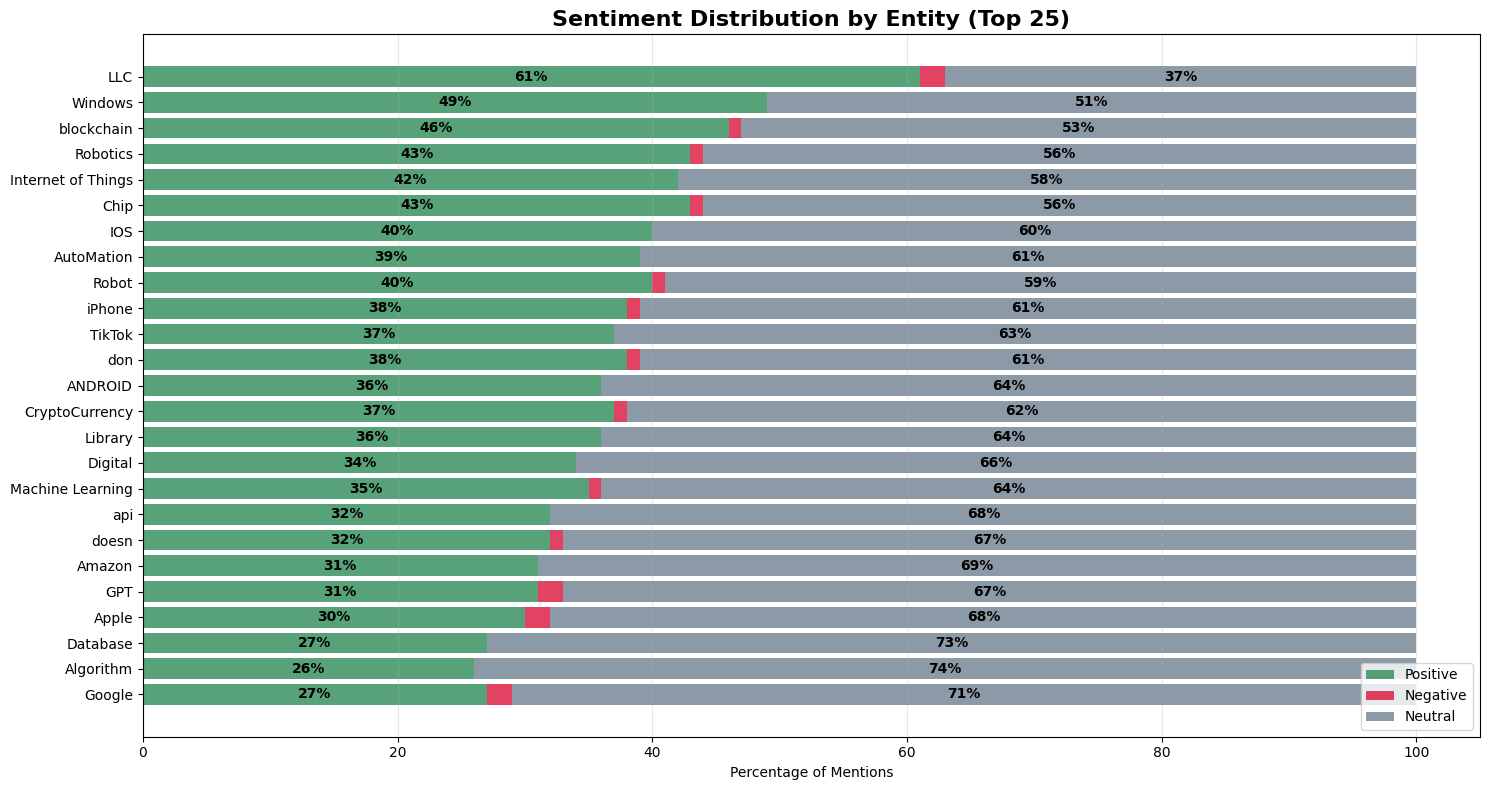

Creating sentiment score scatter plot...


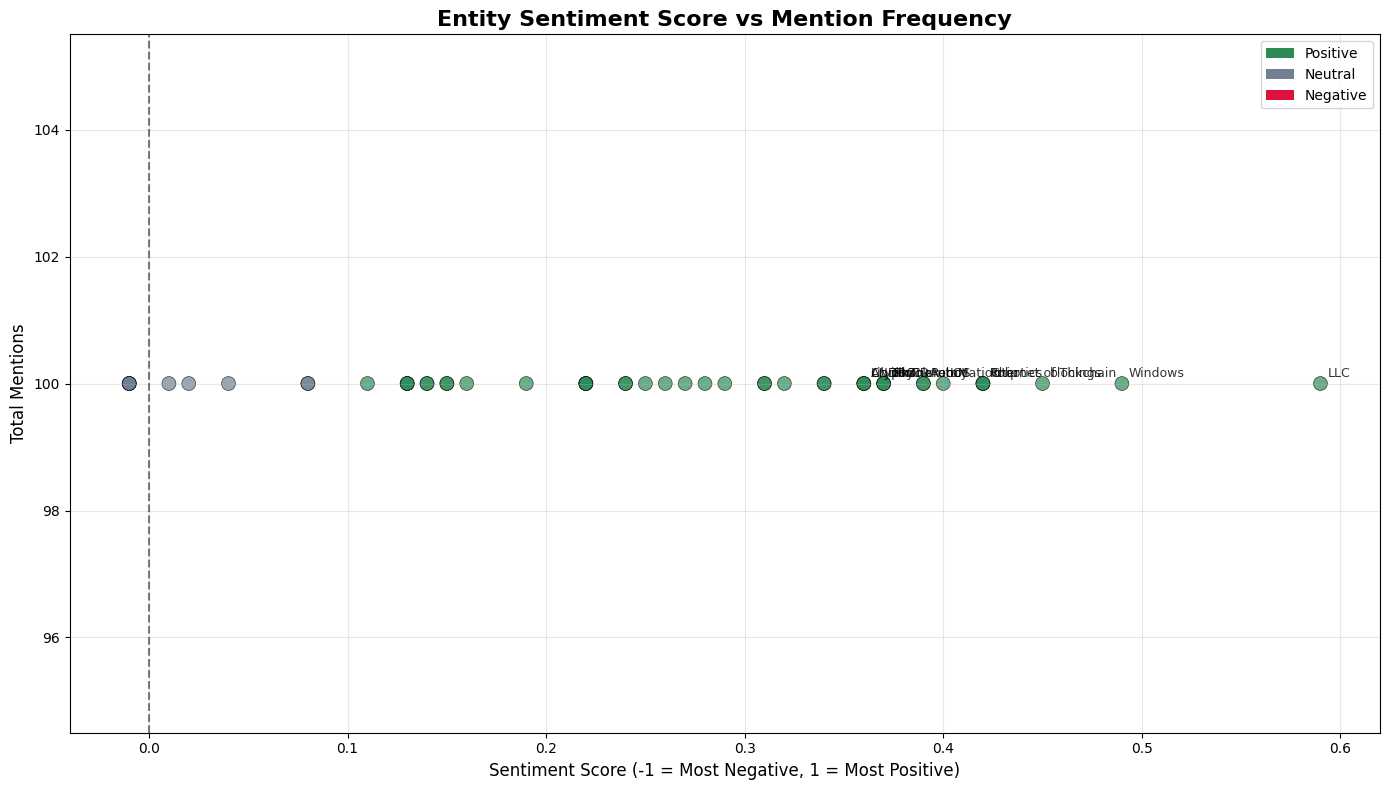

Creating sentiment heatmap...


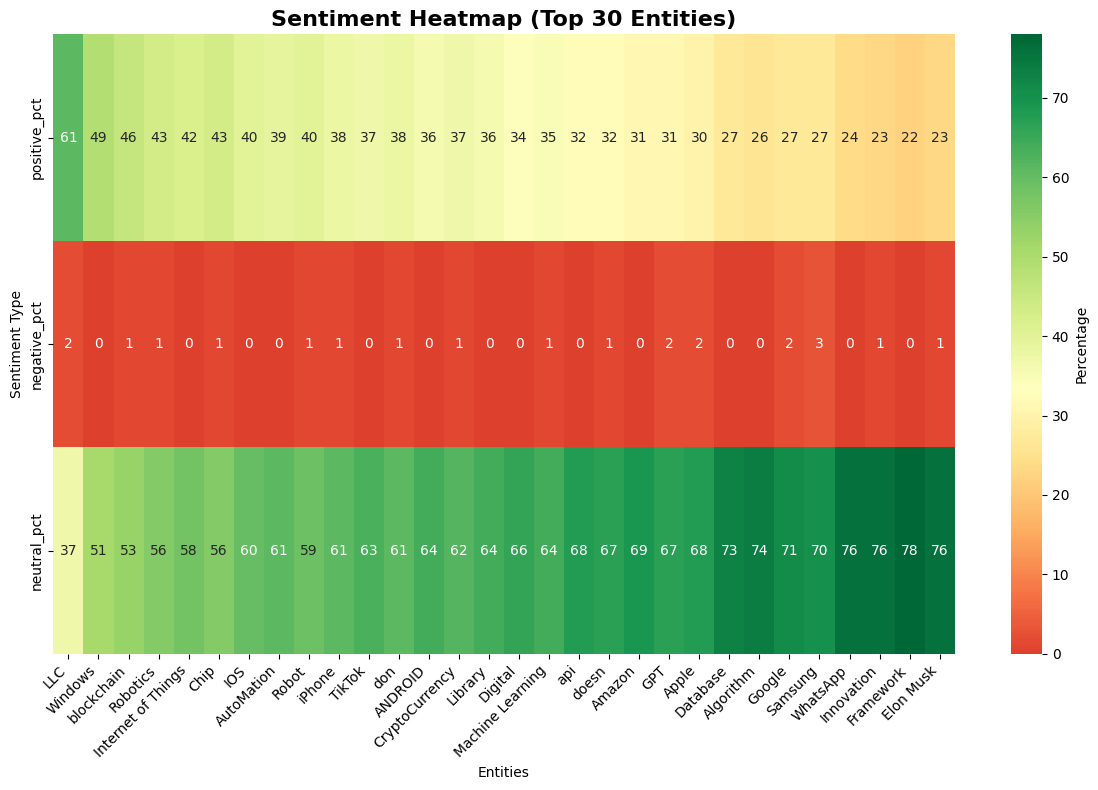

Creating summary statistics plots...


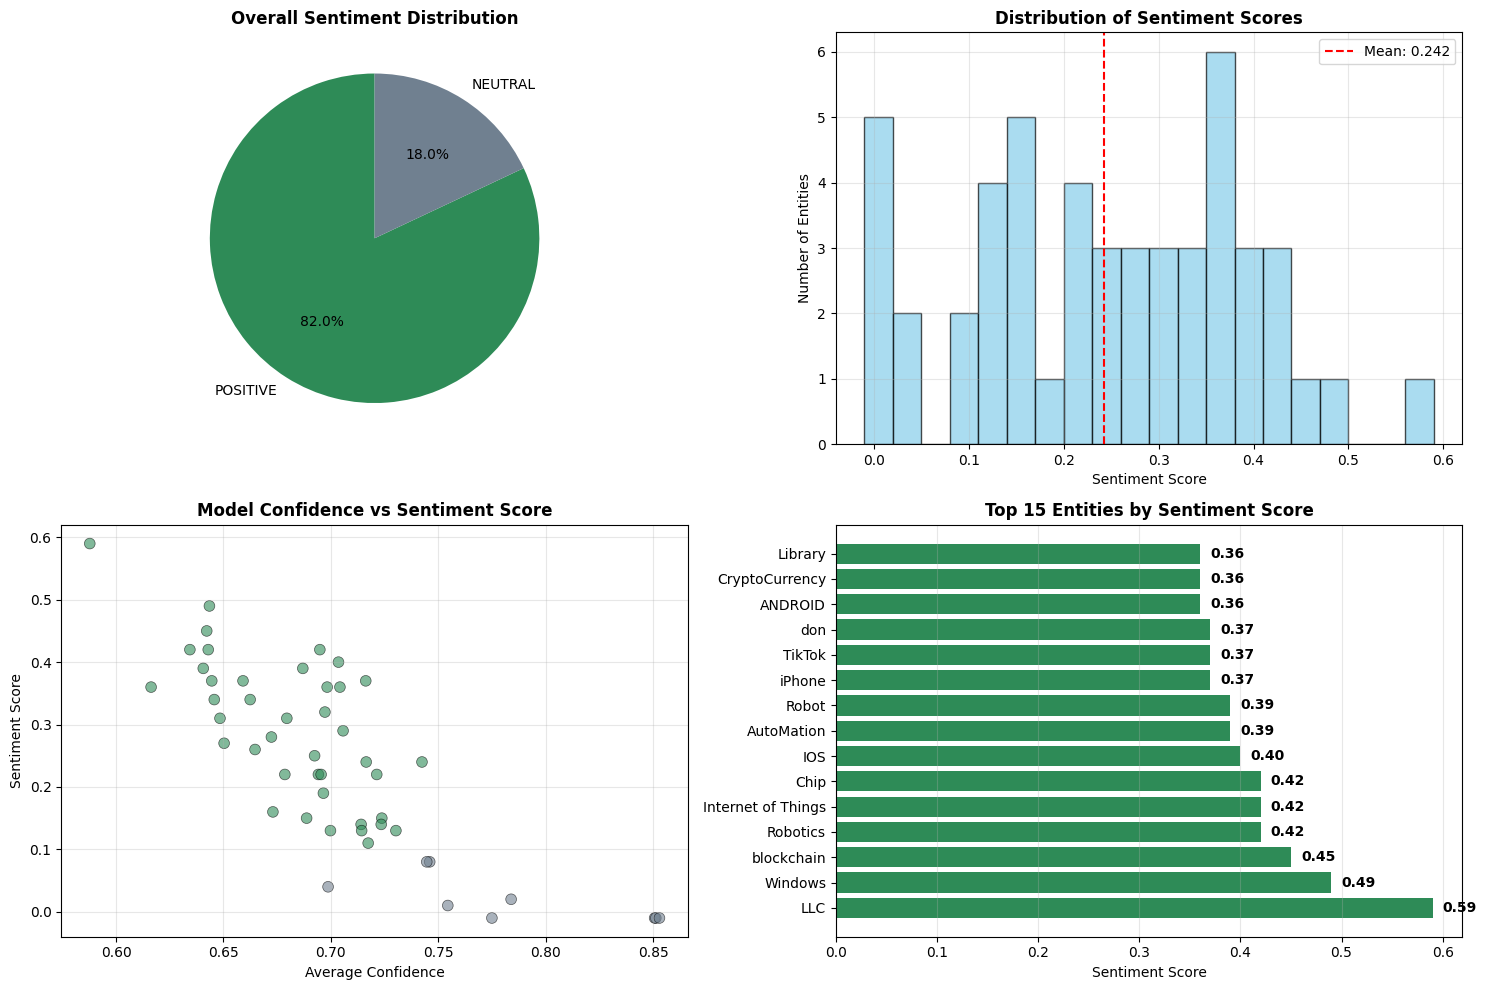

Creating interactive dashboard...


Creating interactive bubble chart...


Creating interactive ranking chart...



Visualization complete!


In [21]:
# Load and visualize your results
visualizer = run_complete_visualization("summary_entity_sentiment_results.csv")


In [25]:
def create_entity_ranking_chart(self) -> go.Figure:
    """
    Create an interactive ranking chart showing entities by sentiment - FIXED VERSION
    """
    # Sort by sentiment score
    df_sorted = self.df.sort_values('sentiment_score', ascending=True)

    fig = go.Figure()

    # Create horizontal bar chart
    fig.add_trace(go.Bar(
        y=df_sorted['entity'],
        x=df_sorted['sentiment_score'],
        orientation='h',
        marker=dict(
            color=df_sorted['sentiment_score'],
            colorscale='RdYlGn',
            colorbar=dict(title="Sentiment Score"),
            line=dict(color='black', width=1)
        ),
        hovertemplate=
        '<b>%{y}</b><br>' +
        'Sentiment Score: %{x:.3f}<br>' +
        'Total Mentions: %{customdata[0]}<br>' +
        'Positive: %{customdata[1]:.1f}%<br>' +
        'Negative: %{customdata[2]:.1f}%<br>' +
        'Neutral: %{customdata[3]:.1f}%<br>' +
        '<extra></extra>',
        customdata=np.column_stack((df_sorted['total_mentions'],
                                  df_sorted['positive_pct'],
                                  df_sorted['negative_pct'],
                                  df_sorted['neutral_pct']))
    ))

    # Calculate proper margins and height
    num_entities = len(df_sorted)
    chart_height = max(600, num_entities * 20)  # More space per entity

    fig.update_layout(
        title='Entity Ranking by Sentiment Score (All Entities)',
        xaxis_title='Sentiment Score',
        yaxis_title='Entities',
        height=chart_height,
        template="plotly_white",
        # Add margins to prevent text cutoff
        margin=dict(l=200, r=100, t=80, b=60),  # Increased left margin for entity names
        # Ensure y-axis shows all labels
        yaxis=dict(
            tickmode='linear',
            dtick=1,  # Show every entity
            tickangle=0,
            tickfont=dict(size=10),
            automargin=True
        ),
        xaxis=dict(
            tickfont=dict(size=10),
            gridcolor='lightgray',
            gridwidth=1
        )
    )

    # Add reference line at zero - positioned correctly
    fig.add_vline(
        x=0,
        line_dash="dash",
        line_color="black",
        line_width=2,
        annotation=dict(
            text="Neutral",
            textangle=90,
            xanchor="center",
            yanchor="bottom",
            x=0,
            y=1.02,  # Position above the chart area
            yref="paper",
            showarrow=False,
            font=dict(size=12, color="black")
        )
    )

    # Add subtle background shading for positive/negative regions
    fig.add_vrect(
        x0=-1, x1=0,
        fillcolor="red", opacity=0.1,
        layer="below", line_width=0,
        annotation_text="Negative", annotation_position="top left"
    )

    fig.add_vrect(
        x0=0, x1=1,
        fillcolor="green", opacity=0.1,
        layer="below", line_width=0,
        annotation_text="Positive", annotation_position="top right"
    )

    return fig

# Alternative version with even better text handling
def create_entity_ranking_chart_alt(self) -> go.Figure:
    """
    Alternative version with enhanced text handling and formatting
    """
    # Sort by sentiment score
    df_sorted = self.df.sort_values('sentiment_score', ascending=True)

    # Truncate long entity names for better display
    df_display = df_sorted.copy()
    df_display['entity_display'] = df_display['entity'].apply(
        lambda x: x if len(x) <= 25 else x[:22] + "..."
    )

    fig = go.Figure()

    # Create horizontal bar chart with improved formatting
    fig.add_trace(go.Bar(
        y=df_display['entity_display'],
        x=df_display['sentiment_score'],
        orientation='h',
        marker=dict(
            color=df_display['sentiment_score'],
            colorscale='RdYlGn',
            colorbar=dict(
                title="Sentiment Score",
                titleside="right",
                tickvals=[-0.5, -0.25, 0, 0.25, 0.5],
                ticktext=['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']
            ),
            line=dict(color='rgba(0,0,0,0.3)', width=0.5)
        ),
        hovertemplate=
        '<b>%{customdata[4]}</b><br>' +  # Full entity name in hover
        'Sentiment Score: %{x:.3f}<br>' +
        'Total Mentions: %{customdata[0]}<br>' +
        'Positive: %{customdata[1]:.1f}%<br>' +
        'Negative: %{customdata[2]:.1f}%<br>' +
        'Neutral: %{customdata[3]:.1f}%<br>' +
        '<extra></extra>',
        customdata=np.column_stack((
            df_sorted['total_mentions'],
            df_sorted['positive_pct'],
            df_sorted['negative_pct'],
            df_sorted['neutral_pct'],
            df_sorted['entity']  # Full entity name for hover
        ))
    ))

    # Enhanced layout with better spacing
    num_entities = len(df_sorted)
    chart_height = max(700, num_entities * 18)

    fig.update_layout(
        title=dict(
            text='Entity Ranking by Sentiment Score<br><sub>Hover for detailed information</sub>',
            x=0.5,
            font=dict(size=16)
        ),
        xaxis_title='Sentiment Score',
        yaxis_title='Entities (sorted by sentiment)',
        height=chart_height,
        width=1000,
        template="plotly_white",
        margin=dict(l=250, r=120, t=100, b=80),

        # Y-axis configuration to prevent text overlap
        yaxis=dict(
            tickmode='array',
            tickvals=list(range(len(df_display))),
            ticktext=df_display['entity_display'].tolist(),
            tickfont=dict(size=9),
            automargin=True,
            side='left'
        ),

        # X-axis configuration
        xaxis=dict(
            tickfont=dict(size=10),
            gridcolor='lightgray',
            gridwidth=1,
            zeroline=True,
            zerolinecolor='black',
            zerolinewidth=2
        ),

        # Add some padding
        plot_bgcolor='white'
    )

    # Add annotations for context
    fig.add_annotation(
        x=0,
        y=len(df_sorted) + 1,
        text="Neutral Line",
        showarrow=True,
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="black",
        font=dict(size=10, color="black"),
        bgcolor="white",
        bordercolor="black",
        borderwidth=1
    )

    # Add summary statistics as text
    mean_score = df_sorted['sentiment_score'].mean()
    fig.add_annotation(
        text=f"Average Sentiment Score: {mean_score:.3f}",
        xref="paper", yref="paper",
        x=0.02, y=0.98,
        xanchor="left", yanchor="top",
        showarrow=False,
        font=dict(size=12, color="black"),
        bgcolor="rgba(255,255,255,0.8)",
        bordercolor="black",
        borderwidth=1
    )

    return fig


In [28]:
def create_fixed_ranking_chart(df, title="Entity Ranking by Sentiment Score"):
    """
    Standalone function to create the fixed ranking chart
    """
    # Sort by sentiment score
    df_sorted = df.sort_values('sentiment_score', ascending=True)

    fig = go.Figure()

    # Create bars
    fig.add_trace(go.Bar(
        y=df_sorted['entity'],
        x=df_sorted['sentiment_score'],
        orientation='h',
        marker=dict(
            color=df_sorted['sentiment_score'],
            colorscale='RdYlGn',
            colorbar=dict(title="Sentiment Score"),
            line=dict(color='black', width=0.5)
        ),
        text=[f"{score:.3f}" for score in df_sorted['sentiment_score']],
        textposition='outside',
        textfont=dict(size=8)
    ))

    fig.update_layout(
        title=title,
        xaxis_title='Sentiment Score',
        yaxis_title='Entities',
        height=max(600, len(df_sorted) * 20),
        margin=dict(l=200, r=100, t=60, b=40),
        template="plotly_white",
        yaxis=dict(automargin=True, tickfont=dict(size=10)),
        xaxis=dict(gridcolor='lightgray')
    )

    # Add neutral line
    fig.add_vline(x=0, line_dash="dash", line_color="black",
                  annotation_text="Neutral", annotation_position="top")

    return fig

In [29]:
fig = create_fixed_ranking_chart(summary_results)
fig.show()